# Hyderabad Neighborhood Data Scarping

## Scraping using Beautiful Soup library

### Reading the html text using *Requests* library into *url* variable and making a BeautifulSoup object named *soup*

In [4]:
url= requests.get('https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Hyderabad').text

In [10]:
soup= BeautifulSoup(url,'html.parser')

In [32]:
con2= soup.find('body').find('div',attrs={'id':'content'}).find('div',attrs={'id':'bodyContent'}).find('div',attrs={'id':'mw-content-text'}).find('div',attrs={'class':'mw-parser-output'})

In [167]:
l=[]
j=9
while j<40:
    for row in con2.find_all('ul')[j].find_all('li'):
        l.append(row.text)
    j+=1

In [170]:
hyd1= pd.DataFrame({'Areas':l})

In [171]:
hyd1

,Areas
0,Ameerpet
1,Begumpet
2,SR Nagar
3,Prakash Nagar
4,Punjagutta
...,...
239,Narsingi
240,Puppalguda
241,Shamshabad
242,Rajiv Gandhi International Airport


In [172]:
hyd1.shape

(244, 1)

# Location data for HyderabadNeighborhoods

## Obtaining the location specific data from the *geocoder* library

In [174]:
import geocoder

In [181]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Hyderabad, India'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [182]:
# call the function to get the coordinates, store in a new list using list comprehension
coords = [get_latlng(neighborhood) for neighborhood in hyd1["Areas"].tolist()]

In [193]:
cords= pd.DataFrame(coords,columns=['Lat','Long'])

In [210]:
hyd_data= hyd1.join(cords)

In [211]:
hyd_data

,Areas,Lat,Long
0,Ameerpet,17.43535,78.44861
1,Begumpet,17.44729,78.45396
2,SR Nagar,17.49808,78.46963
3,Prakash Nagar,17.36069,78.41634
4,Punjagutta,17.42616,78.45210
...,...,...,...
239,Narsingi,17.39114,78.35790
240,Puppalguda,17.39861,78.38234
241,Shamshabad,17.27439,78.41095
242,Rajiv Gandhi International Airport,17.25466,78.42266


In [212]:
# save the DataFrame as CSV file
hyd_data.to_csv("Hyderabad Geospatial Data.csv", index=False)

# Creating a map of Hyderabad with its neighborhoods

In [205]:
import folium
from geopy.geocoders import Nominatim

In [208]:
address = 'Hyderabad, India'

geolocator = Nominatim(user_agent="india-explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Hyderabad, India = {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Hyderabad, India = 17.360589, 78.4740613.


In [214]:
# create map of Hyderabad using latitude and longitude values
map_hyd = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(hyd_data['Lat'], hyd_data['Long'], hyd_data['Areas']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_hyd)  
    
map_hyd

In [215]:
# save the map as HTML file
map_hyd.save('map_hyd_areas.html')

# Using Foursquare API to explore the neighborhoods

In [216]:
CLIENT_ID = 'DXW5ZBA4MKFPDUSEAM2V4AIWX4ODR0HPNCJHHZARKFLECV31' # your Foursquare ID
CLIENT_SECRET = '0CEGWDOPHLIBSE4V5QAJIWVTJJSLADWV2CT1Q4QQASZYAAXO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DXW5ZBA4MKFPDUSEAM2V4AIWX4ODR0HPNCJHHZARKFLECV31
CLIENT_SECRET:0CEGWDOPHLIBSE4V5QAJIWVTJJSLADWV2CT1Q4QQASZYAAXO


### Installing and Importing required libraries

In [217]:
import json # library to handle JSON files

!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

### Creating a function to find the upto top 100 venues in a radius of 2000 meters for each Neighborhood

In [337]:
def getNearbyVenues(names, latitudes, longitudes, radius=7000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            print(f'--------Passing {name}--------')
            pass
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [338]:
hyd_venues= getNearbyVenues(hyd_data['Neighborhood'],hyd_data['Lat'], hyd_data['Long'])

Ameerpet
Begumpet
SR Nagar
Prakash Nagar
Punjagutta
Balkampet
Sanathnagar
Bharat Nagar
Erragadda
Borabanda
Moti Nagar
Khairtabad
Somajiguda
Raj Bhavan Road
Lakdikapool
Saifabad
A.C. Guards
Masab Tank
Chintal Basti
Musheerabad
Chikkadpally
Himayatnagar
Ashok Nagar
Domalguda
Hyderguda
Ramnagar
Azamabad
Adikmet
Nallakunta
Shanker Mutt
RTC X Roads
Bagh Lingampally
Vidyanagar
Amberpet
Tilaknagar
Golnaka
Barkatpura
Shivam Road
Jamia Osmania
Kachiguda
Badichowdi
Nampally
Abids
Aghapura
Koti
Bank Street
Boggulkunta
Secunderabad
Chilkalguda
Kavadiguda
MG Road (James Street)
Madannapet
Minister Road
Mylargadda
Namalagundu
Padmarao Nagar
Pan bazar
--------Passing Pan bazar--------
Parsigutta
Patny
Rani Gunj
RP Road
Sindhi Colony
Sitaphalmandi
Tarnaka
Warsiguda
Secunderabad Cantonment
Bowenpally
Karkhana
Marredpally
Sikh Village
Trimulgherry
Vikrampuri
Afzal Gunj
Aliabad
Alijah Kotla
Asif Nagar
Azampura
Barkas
Bazarghat
Begum Bazaar
Chaderghat
Chanchalguda
Chandrayan Gutta
Chatta Bazaar
Dabirpura


In [339]:
hyd_venues.head(25)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ameerpet,17.43535,78.44861,Mekong,17.437151,78.454301,Chinese Restaurant
1,Ameerpet,17.43535,78.44861,10 Downing Street,17.435868,78.457443,Pub
2,Ameerpet,17.43535,78.44861,Kebabs & Kurries,17.432374,78.457585,Indian Restaurant
3,Ameerpet,17.43535,78.44861,Kakatiya Deluxe Mess,17.433435,78.447090,Diner
4,Ameerpet,17.43535,78.44861,Lamakaan,17.421017,78.447474,Performing Arts Venue
5,Ameerpet,17.43535,78.44861,Meridian Resturant,17.427355,78.452159,Fast Food Restaurant
6,Ameerpet,17.43535,78.44861,Naturals Ice Cream,17.428536,78.439620,Ice Cream Shop
7,Ameerpet,17.43535,78.44861,Vivanta by Taj,17.443498,78.460556,Hotel
8,Ameerpet,17.43535,78.44861,Minerva Coffee Shop,17.428839,78.455573,Indian Restaurant
9,Ameerpet,17.43535,78.44861,Park Hyatt Hyderabad,17.424764,78.429600,Hotel


Let's checkout the number of venues for each neighborhood

In [340]:
hyd_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
A. S. Rao Nagar,100,100,100,100,100,100
A.C. Guards,100,100,100,100,100,100
Abids,100,100,100,100,100,100
Adikmet,100,100,100,100,100,100
Afzal Gunj,100,100,100,100,100,100
...,...,...,...,...,...,...
Vinayak Nagar,37,37,37,37,37,37
Warsiguda,100,100,100,100,100,100
Yakutpura,81,81,81,81,81,81


In [341]:
print('There are {} uniques categories.'.format(len(hyd_venues['Venue Category'].unique())))

There are 137 uniques categories.


## Analyzing Each Neighborhood

### One hot encoding

In [342]:
hyd_onehot = pd.get_dummies(hyd_venues[['Venue Category']], prefix="", prefix_sep="")
hyd_onehot['Neighborhood'] = hyd_venues['Neighborhood'] 
x= hyd_onehot.pop('Neighborhood')
hyd_onehot.insert(0,'Neighborhood',x)

hyd_onehot

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Supermarket,Taxi Stand,Tea Room,Temple,Thai Restaurant,Train Station,Vegetarian / Vegan Restaurant,Water Park,Women's Store,Zoo
0,Ameerpet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Ameerpet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ameerpet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ameerpet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ameerpet,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17467,Umdanagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17468,Umdanagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17469,Umdanagar,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17470,Umdanagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Number of Shopping Malls in total in Hyderabad

In [237]:
hyd_onehot[[i for i in hyd_onehot.keys() if 'Mall' in i]].value_counts()

Shopping Mall
0                6837
1                 108
dtype: int64

### Creating a new data frame for shopping malls only

In [343]:
hyd_malls= hyd_onehot[['Neighborhood','Shopping Mall']]

In [344]:
mean_malls= hyd_malls.groupby('Neighborhood').agg({'Shopping Mall':'mean'})

In [345]:
mean_malls.reset_index(inplace=True)

In [359]:
mean_malls

,Neighborhood,Shopping Mall
0,A. S. Rao Nagar,0.010000
1,A.C. Guards,0.020000
2,Abids,0.020000
3,Adikmet,0.000000
4,Afzal Gunj,0.020000
...,...,...
238,Vinayak Nagar,0.000000
239,Warsiguda,0.000000
240,Yakutpura,0.012346
241,Yapral,0.025000


## Clustering the Neighborhoods

In [303]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import matplotlib

### Finding the Optimum k value using Elbow method

In [347]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(hyd_clustering)
 
    distortions.append(sum(np.min(cdist(hyd_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / hyd_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(hyd_clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / hyd_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_

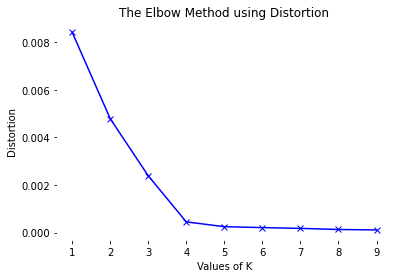

In [348]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

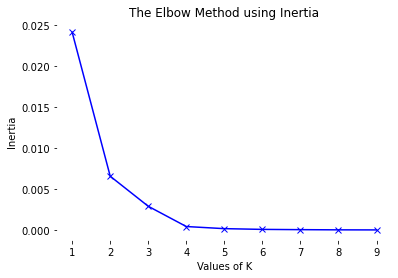

In [349]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

As we can see, the value of k=3 provides the most optimal clustering result. Carrying on with k=4, we get;

In [351]:
k = 4

hyd_clustering = mean_malls.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=k, random_state=0).fit(hyd_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 1, 1, 0, 1, 1, 3, 3, 2, 1, 0, 0, 3, 0, 0, 0, 1, 1, 3, 1, 0, 0,
       0, 3, 3, 0, 1, 0, 3, 0, 1, 1, 0, 3, 1, 0, 1, 3, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 2, 3, 1, 3, 3, 3, 0, 3, 0, 1, 1, 0, 3, 1, 0, 1, 3,
       3, 1, 1, 3, 0, 0, 0, 2, 3, 1, 1, 0, 1, 0, 0, 0, 3, 3, 0, 0, 2, 1,
       0, 2, 0, 0, 1, 1, 3, 0, 0, 0, 0, 3, 0, 1, 3, 0, 3, 3, 2, 0, 0, 1,
       0, 1, 1, 2, 2, 1, 1, 3, 1, 0, 0, 0, 1, 1, 0, 2, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 3, 0, 0, 1, 1, 3, 1, 1, 3, 1, 0, 1, 0, 1, 3, 0, 1,
       2, 0, 3, 0, 1, 3, 1, 3, 1, 3, 0, 1, 1, 1, 0, 0, 1, 3, 3, 3, 0, 3,
       0, 0, 3, 0, 1, 1, 3, 1, 1, 1, 0, 2, 0, 0, 3, 3, 0, 0, 0, 3, 1, 3,
       1, 0, 0, 0, 3, 0, 1, 1, 1, 0, 3, 3, 0, 3, 1, 1, 0, 0, 3, 0, 3, 3,
       0, 3, 0, 3, 1, 1, 0, 3, 1, 0, 3, 0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 1,
       1])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [352]:
# add clustering labels
hyd_merged = mean_malls.copy()
hyd_merged['Cluster Lables'] = kmeans.labels_

# merge hyd_grouped with hyd to add latitude/longitude for each neighborhood
hyd_data.rename(columns={'Areas':'Neighborhood'},inplace=True)
hyd_merged = hyd_merged.join(hyd_data.set_index('Neighborhood'), on='Neighborhood')

hyd_merged.head() # check the last columns!

,Neighborhood,Shopping Mall,Cluster Lables,Lat,Long
0,A. S. Rao Nagar,0.01,3,17.411200,78.508240
1,A.C. Guards,0.02,1,17.395015,78.459812
2,Abids,0.02,1,17.389800,78.476580
3,Adikmet,0.00,0,17.410610,78.515130
4,Afzal Gunj,0.02,1,17.377510,78.480050


### Top places containing shopping malls

In [353]:
hyd_merged.sort_values(['Shopping Mall'],inplace=True,ascending=False)
hyd_merged

,Neighborhood,Shopping Mall,Cluster Lables,Lat,Long
49,Chengicherla,0.071429,2,17.437070,78.606840
154,Nagaram,0.071429,2,17.489780,78.601400
73,Ghatkesar,0.066667,2,17.463261,78.621118
106,Kismatpur,0.066667,2,17.338750,78.378020
86,Jagadgirigutta,0.058824,2,17.504052,78.420129
...,...,...,...,...,...
164,Neredmet,0.000000,0,17.475699,78.523750
80,Hastinapuram,0.000000,0,17.328300,78.549420
81,Hayathnagar,0.000000,0,17.327100,78.605290
84,IDA Bollaram,0.000000,0,17.554030,78.344590


## Visualize the resulting clusters

In [354]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hyd_merged['Lat'], hyd_merged['Long'], hyd_merged['Neighborhood'], hyd_merged['Cluster Lables']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Examining the Clusters

## Cluster 0

In [355]:
print('There are '+ str(hyd_merged.loc[hyd_merged['Cluster Lables'] == 0].shape[0]) +' shopping malls in cluster 0')
hyd_merged.loc[hyd_merged['Cluster Lables'] == 0]

There are 94 shopping malls in cluster 0


,Neighborhood,Shopping Mall,Cluster Lables,Lat,Long
201,Safilguda,0.0,0,17.466430,78.53565
235,Venkatapuram,0.0,0,17.297260,78.48468
35,Beeramguda,0.0,0,17.517970,78.30146
10,Amberpet,0.0,0,17.385820,78.51836
237,Vikrampuri,0.0,0,17.416730,78.54323
...,...,...,...,...,...
164,Neredmet,0.0,0,17.475699,78.52375
80,Hastinapuram,0.0,0,17.328300,78.54942
81,Hayathnagar,0.0,0,17.327100,78.60529
84,IDA Bollaram,0.0,0,17.554030,78.34459


## Cluster 1

In [356]:
print('There are '+ str(hyd_merged.loc[hyd_merged['Cluster Lables'] == 1].shape[0]) +' shopping malls in cluster 1')
hyd_merged.loc[hyd_merged['Cluster Lables'] == 1]

There are 79 shopping malls in cluster 1


,Neighborhood,Shopping Mall,Cluster Lables,Lat,Long
9,Alwal,0.037037,1,17.535430,78.544270
181,Prakash Nagar,0.037037,1,17.360690,78.416340
167,Old Alwal,0.037037,1,17.535430,78.544270
93,KPHB,0.036145,1,17.493440,78.397020
123,Macha Bollaram,0.032787,1,17.525910,78.376330
...,...,...,...,...,...
5,Aghapura,0.020000,1,17.389150,78.463854
4,Afzal Gunj,0.020000,1,17.377510,78.480050
2,Abids,0.020000,1,17.389800,78.476580
198,Red Hills,0.020000,1,17.397410,78.462740


## Cluster 2

In [357]:
print('There are '+ str(hyd_merged.loc[hyd_merged['Cluster Lables'] == 2].shape[0]) +' shopping malls in cluster 2')
hyd_merged.loc[hyd_merged['Cluster Lables'] == 2]

There are 11 shopping malls in cluster 2


,Neighborhood,Shopping Mall,Cluster Lables,Lat,Long
49,Chengicherla,0.071429,2,17.437070,78.606840
154,Nagaram,0.071429,2,17.489780,78.601400
73,Ghatkesar,0.066667,2,17.463261,78.621118
106,Kismatpur,0.066667,2,17.338750,78.378020
86,Jagadgirigutta,0.058824,2,17.504052,78.420129
113,Kushaiguda,0.050000,2,17.481130,78.583700
114,L. B. Nagar,0.047619,2,17.512650,78.441290
125,Madeenaguda,0.046875,2,17.495380,78.333360
187,RC Puram,0.045455,2,17.521362,78.430604
8,Allwyn Colony,0.044444,2,17.503370,78.416020


## Cluster 3

In [358]:
print('There are '+ str(hyd_merged.loc[hyd_merged['Cluster Lables'] == 3].shape[0]) +' shopping malls in cluster 3')
hyd_merged.loc[hyd_merged['Cluster Lables'] == 3]

There are 60 shopping malls in cluster 3


,Neighborhood,Shopping Mall,Cluster Lables,Lat,Long
65,Falaknuma,0.014925,3,17.337510,78.473860
223,Suchitra Center,0.014925,3,17.500190,78.476880
240,Yakutpura,0.012346,3,17.360930,78.490830
6,Aliabad,0.011628,3,17.342590,78.476260
117,Lal Darwaza,0.010753,3,17.346230,78.477570
233,Uppuguda,0.010309,3,17.350050,78.488530
56,Dabirpura,0.010309,3,17.366180,78.487360
218,Sikh Village,0.010000,3,17.458700,78.493080
227,Tilaknagar,0.010000,3,17.392610,78.507190
230,Udden Gadda,0.010000,3,17.394870,78.470760


# Observations:

Looking at the spread of the shopping malls around Hyderabad, there is definitely a high density of shopping malls around the Western parts of the city. Also, in the north western part of the city lies the IT-industry of hyderabad, which sees a lot of footfall compared to many other areas in the city's Western part. However, the land lease rates in these areas are amongst the highest in hyderabad and also the exsisting shopping malls are yet to be filled with retailers/franchises, which should be seen as a critical point while considering this particular location. The Eastern part of the city looks like the best pick so far, with the low land lease rates, moderate amount of population/footfall and low competition from the sporadically spread shopping malls.